# PACSPP - 401003: Introduction to Neural Networks
## Homework Challenge: Convolutional Neural Network
**GEC**

**Instructor**: Prof. Pavlos Protopapas<br />
**Maximum Score**: 100

<hr style="height:2.4pt">

### INSTRUCTIONS


- This homework is a jupyter notebook. Download and work on it on your local machine.

- This homework should be submitted in pairs.

- Ensure you and your partner together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code. 

- Please use .head() when viewing data. Do not submit a notebook that is *excessively long*. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, *not hardcoded*. For example: 

print(f'The R^2 is {R:.4f}')

- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- *Ensure you make appropraite plots for all the questions it is applicable to, regardless of it being explicitly asked for.*

<hr style="height:2pt">

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
<h2>Overview </h2>
In this homework, we will explore Convolutional Neural Networks (CNNs).  We will begin by building a CNN to classify Architectural Heritage Elements, a standard pedagogical problem, and use saliency maps to understand what the network is paying attention to. We will then see that CNNs aren't just for classifying. They can serve as image input processing for a variety of tasks, as we will show by training a network to rotate faces upright.

    
<br><br>

Convolutional neural networks are computationally intensive. We highly recommend that you train your model on a system using GPUs (take a look at Google Colab's runtime settings for accessing a GPU environment free of cost). On CPUs, this training can take over an hour. On GPUs, it can be done within minutes. If you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your model weights as explicitly detailed in **Part 2**, where it is required to save your weights.
  
</div>

## **RUN THESE CELLS FIRST IN COLAB**

In [ ]:
# INSTALL NECESSARY PACKAGES IN COLAB
!pip install --upgrade --no-cache-dir gdown
!pip install tf_keras_vis

In [ ]:
# TEST FOR GPU DEVICE IN COLAB
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# LOAD DATASET AND MODELS FROM GOOGLE DRIVE IN COLAB
import os
import shutil
from zipfile import ZipFile
from google.colab import drive

# mount google drive on this virtual machine
drive.mount('/content/drive')

# specifying the zip file name 
file_path = "/content/drive/MyDrive/data_zip/Homework2.zip"

# opening the zip file in READ mode, extracting all the files
with ZipFile(file_path, 'r') as zip_f:
    print('-NOTICE: extracting all the files now.')
    zip_f.extractall('/content/data')
    print(f'-NOTICE: {file_path} extraction completed.')

# copy models on google drive to current workspace
source_dir = '/content/drive/MyDrive/model'
target_dir = '/content/model/'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for file in os.listdir(source_dir):
    source = os.path.join(source_dir,file)
    shutil.copy(source, target_dir)
    print(f'-NOTICE: model {file} copied successfully.')

---
## **HOMEWORK STARTS FROM HERE**

In [4]:
# Declare some of the global configures
IS_COLAB    = True     # is this notebook running on colab
PATH_PREFIX = '/content/' if IS_COLAB else './'     # prefix of paths
LOAD_MODELS = {         # use trained model to skip training or not
    # NOTE the names of saved models: {model.name}_{epochs}.h5
    'Part1'   : False,
    'Part2_R' : False,
    'Part2_C' : False,
}

TITLE_SIZE  = 14        # font size of title in plt image
LABEL_SIZE  = 10        # font size of axis-label in plt image
IMG_SIZE    = (128,128) # size of original input data image

In [5]:
# Import libraries for this notebook
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import cm
from keras.optimizers import Adam
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from keras.models import Sequential, Model
from sklearn.metrics import classification_report
from tf_keras_vis.utils.scores import CategoricalScore
from keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from sklearn.metrics import accuracy_score, mean_squared_error
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, Input

---

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
<h2> Part 1: Building a Basic CNN Model [50pts] </h2> 

In this question, you will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [Architectural Heritage Elements Dataset (AHED)](https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset), which consists of 10235 images classified in 10 categories: Altar: 829 images; Apse: 514 images; Bell tower: 1059 images; Column: 1919 images; Dome (inner): 616 images; Dome (outer): 1177 images; Flying buttress: 407 images; Gargoyle (and Chimera): 1571 images; Stained glass: 1033 images; Vault: 1110 images.

**Question 1.1**: [20pts] Create an ImageDataGenerator for data augmentation. 

- **1.1.1:** [8pts] Create the main DataGenerator object with arguments of your choice. Apply these two including arguments of your choice:
  - rescale=1./255
  - validation_split=0.2

- **1.1.2:** [8pts] Use the above created DataGenerator object to creat 2 generators: traingen and valgen. Apply arguments of your choice. Make sure to use:
  - `shuffle=True` in traingen.
  - `shuffle=False` in valgen.

- **1.1.3:** [4pts] Visualize the augmented data.
  - Visualize a few images from the train and test data.
    
**Question 1.2**: [22pts] Build a CNN classifier to classify images in the AHED dataset.
  
- **1.2.1:** [10pts] Use a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order, and you can use as many layers as you'd like) to build your classification model. You may use an existing architecture like AlexNet or VGG16, or create one of your own design. However, you should **construct the network yourself** and not use a pre-written implementation.
- **1.2.2:** [4pts] Take your model from above and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Your validation accuracy should exceed 65%. 
- **1.2.3:** [6pts] Plot the loss and accuracy (both train and valid) for your chosen architecture in the **same plot**.
- **1.2.4:** [2pt] Save the model weights in a file.

**Question 1.3**: [8pts] Visualizing results

- **1.3.1:** [2pts] Generate a classification report.

- **1.3.2:** [2pts] Visualizing image from class with highest f1-score.
  - Load and plot an image from the class which has the highest f1-score.
  
- **1.3.3:** [2pts] Visualizing saliency maps for the class with highest f1-score.
    
    One of the ways to visualize your model is using [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input image. We will also use [Grad-CAM](https://arxiv.org/abs/1610.02391), which has been shown to better indicate the attention of CNNs.

  - For the same input image as in **3.2**, generate and plot a saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM heatmap. 
  - Arrange the three plots in a row using subplots: Original Image, Saliency Map, GradCAM. 
    - Create Saliency object.
    - Define loss function. Pass it the correct class label.
    - Generate saliency map with smoothing that reduce noise by adding noise.
    - Create Gradcam object.
    - Generate heatmap with GradCAM.
- **1.3.4:** [2pts] Which visualization is easier to understand in your case, and what does the network seem to be focusing on?
    
**Note:** This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html); the `jet` colormap is harder to interpret than sequential ones.

**Question 1.1**: [20pts] Create an ImageDataGenerator for data augmentation.

**1.1.1:** [8pts] Create the main DataGenerator object with arguments of your choice.

In [6]:
# Create main generator
datagen = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.2,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
)

**1.1.2:** [8pts] Use the above created DataGenerator object to creat 2 generators: traingen and valgen.

In [7]:
# Declare some hyperparameter for DataGenerator
BATCH_SIZE  = 128
RANDOM_SEED = 114568

# Create generator for training data
traingen = datagen.flow_from_directory(
    directory = PATH_PREFIX + 'data/Part1',
    target_size = IMG_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'training'
)

# Create generator for validation data
valgen = datagen.flow_from_directory(
    directory = PATH_PREFIX + 'data/Part1',
    target_size = IMG_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = RANDOM_SEED,
    subset = 'validation'
)

Found 8438 images belonging to 11 classes.
Found 2103 images belonging to 11 classes.


**1.1.3:** [4pts] Visualize the augmented data.

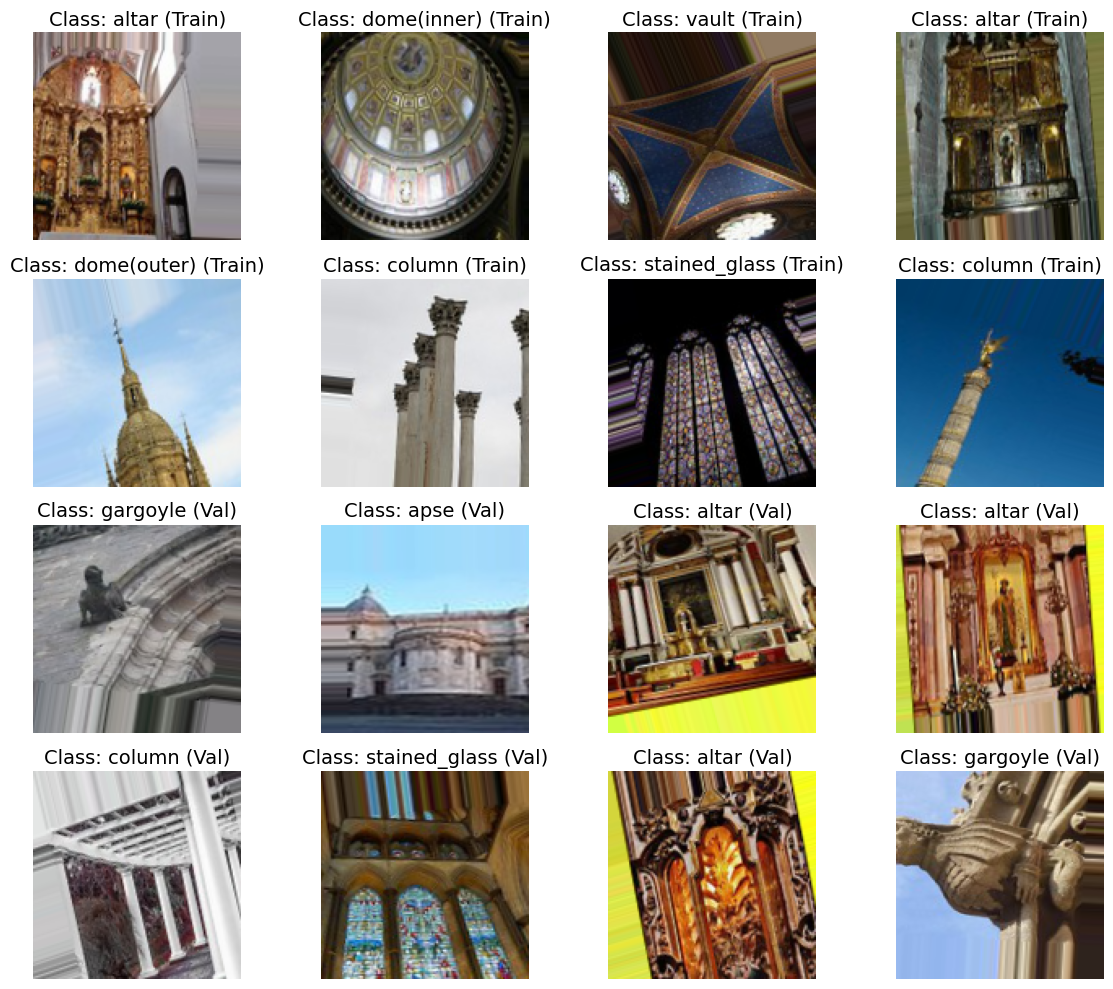

In [8]:
class_name = ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'portal', 'stained_glass', 'vault']

TOTAL_TRA_BATCH = int(np.ceil(traingen.samples/BATCH_SIZE))
TOTAL_VAL_BATCH = int(np.ceil(valgen.samples/BATCH_SIZE))

fig, axs = plt.subplots(4, 4, figsize=(12,10))

# Randomly show 8 images from traingen
for ax in axs.flat[0:8]:
    batch = np.random.randint(0, TOTAL_TRA_BATCH-1)
    b_index = np.random.randint(0, BATCH_SIZE)
    img = traingen[batch][0][b_index]
    name = class_name[traingen.classes[traingen.index_array[batch*BATCH_SIZE+b_index]]]
    ax.imshow(img)
    ax.set_title(f'Class: {name} (Train)', fontsize=TITLE_SIZE)
    ax.axis('off')

# Randomly show 8 images from valgen
for ax in axs.flat[8:16]:
    batch = np.random.randint(0, TOTAL_VAL_BATCH-1)
    b_index = np.random.randint(0, BATCH_SIZE)
    img = valgen[batch][0][b_index]
    name = class_name[valgen.classes[valgen.index_array[batch*BATCH_SIZE+b_index]]]
    ax.imshow(img)
    ax.set_title(f'Class: {name} (Val)', fontsize=TITLE_SIZE)
    ax.axis('off')

# Show the augmented data
fig.tight_layout()
fig.show()

**Question 1.2**: [22pts] Build a CNN classifier to classify images in the AHED dataset.

**1.2.1:** [10pts] Build a CNN classifier to classify images in the AHED dataset.

In [9]:
# cnn_model_new ###########################################################################
model_1 = Sequential(name='cnn_model_new')
model_1.add(Conv2D(32, (3,3), input_shape=IMG_SIZE+(3,), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_1.add(MaxPooling2D())
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dense(11, activation='softmax'))

In [10]:
# Compile the CNN model
model_1.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Take a look at the model summary
model_1.summary()

Model: "cnn_model_new"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                 

**1.2.2:** [4pts] Take your model from above and train it.

In [11]:
# Define epochs for training
EPOCHS  = 30

# Dedine path to save model, and declare a bool type variable for skipping training
save_model_path = f'{PATH_PREFIX}model/{model_1.name}_{EPOCHS}.h5'
is_skip = (LOAD_MODELS['Part1']) and (os.path.exists(save_model_path))

# If skip training, use pretrained model
if is_skip:
    model_1.load_weights(save_model_path)
    print(f'-NOTICE: model load weights form {save_model_path}')

# If not, train a new model with early stopping
else:
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 5,
        verbose = 0,
        restore_best_weights = True
    )

    history = model_1.fit(
        traingen,
        validation_data = valgen,
        epochs = EPOCHS,
        callbacks = [earlystop]
    )

    print(f'-NOTICE: training process has finished.')

Epoch 1/30
66/66 [==============================] - 74s 933ms/step - loss: 1.9428 - accuracy: 0.3322 - val_loss: 1.6141 - val_accuracy: 0.4432
Epoch 2/30
66/66 [==============================] - 64s 972ms/step - loss: 1.4125 - accuracy: 0.5130 - val_loss: 1.3692 - val_accuracy: 0.5012
Epoch 3/30
66/66 [==============================] - 54s 809ms/step - loss: 1.2388 - accuracy: 0.5721 - val_loss: 1.1939 - val_accuracy: 0.5896
Epoch 4/30
66/66 [==============================] - 56s 847ms/step - loss: 1.1020 - accuracy: 0.6265 - val_loss: 1.1079 - val_accuracy: 0.6172
Epoch 5/30
66/66 [==============================] - 61s 925ms/step - loss: 1.0258 - accuracy: 0.6568 - val_loss: 1.0135 - val_accuracy: 0.6553
Epoch 6/30
66/66 [==============================] - 55s 835ms/step - loss: 0.9634 - accuracy: 0.6705 - val_loss: 1.0982 - val_accuracy: 0.6167
Epoch 7/30
66/66 [==============================] - 55s 835ms/step - loss: 0.9087 - accuracy: 0.6906 - val_loss: 0.9842 - val_accuracy: 0.6671

**1.2.3:** [6pts] Plot the loss and accuracy (both train and valid) for your chosen architecture in the **same plot**.

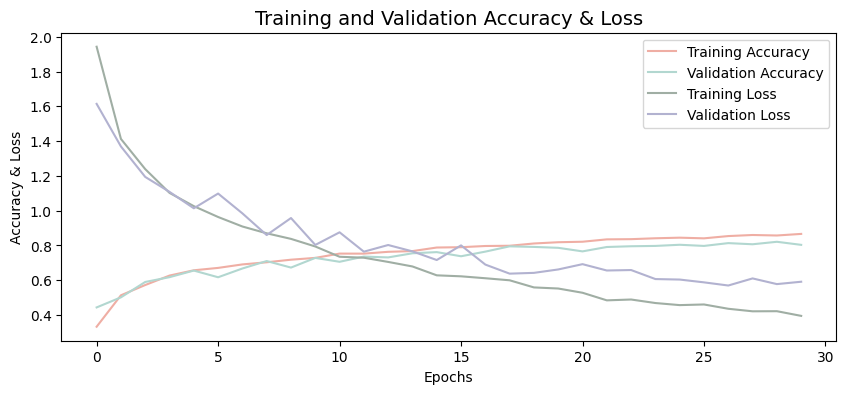

In [12]:
# Plot the loss and accuracy for both training and valid
if not is_skip:
    fig = plt.figure(figsize=(10,4))
    ax = fig.gca()

    ax.plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    ax.plot(history.history['loss'],color='#A0AEA4',label = 'Training Loss')
    ax.plot(history.history['val_loss'],color='#B2B2D0',label = 'Validation Loss')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy & Loss')
    ax.set_title('Training and Validation Accuracy & Loss', fontsize=TITLE_SIZE)

    fig.show()
else:
    print('-NOTICE: skiped training, so no history to plot with.')

**1.2.4:** [2pt] Save the model weights in a file.

In [13]:
# Save the model weights in a file
if not is_skip:
    model_1.save_weights(filepath = save_model_path,save_format='h5')

    # If notebook is running on colab, also copy weights to google drive 
    if IS_COLAB:
        source = save_model_path
        target_dir = '/content/drive/MyDrive/model'
        shutil.copy(source, target_dir)
        print(f'-NOTICE: model copied to google drive successfully.')
else:
    print('-NOTICE: skiped training, so no need to save weights.')

-NOTICE: model copied to google drive successfully.


**Question 1.3**: [8pts] Visualizing results.

**1.3.1:** [2pts] Generate a classification report.

In [14]:
# Get predicted results on valilation data
prediction = model_1.predict(valgen)
y_pred = np.argmax(prediction, axis=1)
y_true = valgen.classes

# Generate a classification report
report = classification_report(y_true, y_pred,digits=5)
print(report)

17/17 [==============================] - 11s 662ms/step
              precision    recall  f1-score   support

           0    0.85000   0.92727   0.88696       165
           1    0.77465   0.53922   0.63584       102
           2    0.77500   0.58768   0.66846       211
           3    0.79762   0.87467   0.83437       383
           4    0.92079   0.75610   0.83036       123
           5    0.72924   0.85957   0.78906       235
           6    0.74194   0.56790   0.64336        81
           7    0.77562   0.89172   0.82963       314
           8    0.63235   0.70492   0.66667        61
           9    0.97030   0.95146   0.96078       206
          10    0.86070   0.77928   0.81797       222

    accuracy                        0.80837      2103
   macro avg    0.80256   0.76725   0.77850      2103
weighted avg    0.81126   0.80837   0.80465      2103



**1.3.2:** [2pts] Visualizing image from class with highest f1-score.

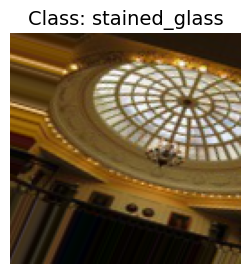

In [15]:
# Define the class label with highest f2-score
HIGHEST_CLASS_LABEL = 9
HIGHEST_CLASS_NAME  = class_name[HIGHEST_CLASS_LABEL]

# Randomly pick a image of given class from valgen
img_index = valgen.index_array[np.random.choice(np.where(valgen.classes==4)[0])]
img = valgen[img_index//BATCH_SIZE][0][img_index%BATCH_SIZE]

# Show the original image
fig = plt.figure(figsize=(3,3))
ax = fig.gca()
ax.imshow(img)
ax.set_title(f'Class: {HIGHEST_CLASS_NAME}', fontsize=TITLE_SIZE)
ax.axis('off')
fig.show()

**1.3.3:** [2pts] Visualizing saliency maps for the class with highest f1-score.

In [16]:
# Define a ReplaceToLinear object to change the activation of the output dense layer
replace2linear = ReplaceToLinear()

# Define loss function, and pass it the correct class label
score = CategoricalScore([HIGHEST_CLASS_LABEL])

# Create Saliency object
saliency = Saliency(
    model = model_1,
    model_modifier = replace2linear,
    clone = True
)

# Generate saliency map with smoothing by adding noise
saliency_map = saliency(
    score = score,
    seed_input = img,
    smooth_samples = 10,
    smooth_noise = 0.2,
    normalize_map = True
)

# Create Gradcam object
gradcam = Gradcam(
    model = model_1,
    model_modifier = replace2linear,
    clone = True
)

# Generate heatmap with GradCAM
cam_map = gradcam(
    score = score,
    seed_input = np.expand_dims(img, axis=0),
    penultimate_layer = -1,
    normalize_cam = True,
)
heatmap = np.uint8(cm.jet(cam_map[0])[...,:3]*255)

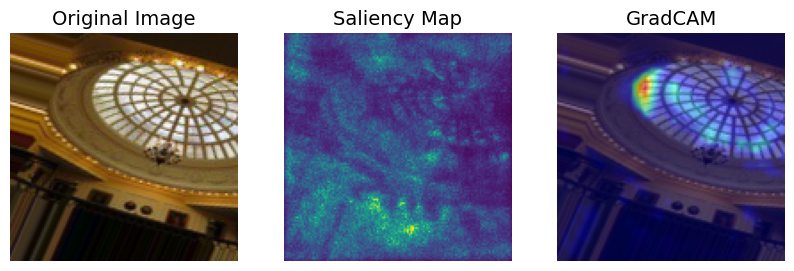

In [17]:
# Arrange the 3 plots in a row using subplots
img_list = [img, saliency_map[0], img]
img_name = ['Original Image', 'Saliency Map', 'GradCAM']
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for i in range(0,3):
    ax = axs[i]
    ax.imshow(img_list[i])
    ax.set_title(img_name[i], fontsize=TITLE_SIZE)
    ax.axis('off')
    if i == 2:
        ax.imshow(heatmap, cmap='jet', alpha=0.5)
fig.show()

**1.3.4:** [2pts] Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

**Answer:** 

- GradCAM is much easier to understand, which directly highlights the areas where cnn model focusd on. Saliency Map is a little bit ambiguous, which seem to highlights a lot of pixels.

- Based on the areas highlighted in GradCAM, the network seems to be focusing on edges and clear lines. It also tends to focus on areas with strong lights (pixels with high value).

---

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
<h2> Part 2: Regression with CNN [50pts total] </h2>

## Problem Statement

In this problem we will construct a neural network to predict *the age of a person using their face*. This is a supervised training application, with faces of people as the input, and their age as the target variable.

</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
<h2> Questions </h2>

### Data preparation [20 points]

**2.1.1[10 points]** **Loading and Thinking about Datasets**.

The dataset given to you is in 2 zip files, one for the train data and one for the test data. The image and label mapping is provided in 2 csv files `age_train_data.csv` and `age_test_data.csv`. Write a function `load_dataset( )` using tensorflow's `ImageDataGenerator` to return a train and validation set from the train data and a test set from the test data. Use a random seed of 100 and 20% of the train data for validation.

**2.1.2[5 points]** **Taking a look**.

In a grid of subplots, plot 9 images from the train data with the titles being the age of the person. The title should have the following format `Age: value`. For example, "Age: 12".


**2.1.3[5 points]** **Conceptual Question**

Dropout layers have been shown to work well for regularizing deep neural networks, and can be used for very little computational cost. 

Write in **3-5 sentences** if it is a good idea to use dropout layers? Explain, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

### Building and training your CNN [24 points]

**2.2.1[10 points]** **Define your regression model**.

Construct a model with multiple Conv layers and any other layers you think would help. Be sure to output `<yourmodelname>.summary()` as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we were able to it with substantially fewer. Any working setup is acceptable though.

**2.2.2[5 points]** **Training your model**.

Train your model using on the train data along with the validation data to understand the training process.

**2.2.3[4 points]** **Evaluating your model**.

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image with the title as the original label and the predicted label.
    
**2.2.4[5 points]** **Define a classification model**.

Using the same architecture as the regression model and only changing the output layer, define a classification model. Convert the regression problem to a classification where each class is a unique age. Train this model using the train data and get the results on the validation data.  
    

### Further Analysis [6 points]

**2.3.1[3 points]** **Compare the performance**.    
    
For the test set, get the predictions from both the regression and classification model. Print the accuracy of the test data from both the models. (Make necessary conversions of the results to compute the accruacy)
 
**2.3.2[3 points]** **Correct an image of your choosing**.

Find an image or image(s) (not from the provided test/training sets), or make your own. Use both the networks to get prediction of the age and compare to their original age. Which model does well? Why do you think this happens, provide atleast 3 reasons?
    
</div>

##### **Question 2.1** Data preparation [20 points]

**2.1.1[10 points]** **Loading and Thinking about Datasets**.

In [18]:
# Declare some hyperparameter for DataGenerator
BATCH_SIZE  = 128
RANDOM_SEED = 100
CLASS_MODE  = 'sparse'

def load_dataset():

    # Load train data and labels
    train_df = pd.read_csv(PATH_PREFIX+'data/Part2/age_train_data.csv')
    age_bias = np.min(np.unique(train_df['age']))
    train_df['age'] = train_df['age'].apply(str)

    # Shuffle the training data
    train_df = train_df.sample(frac=1.0, replace=False)

    # Load test data and labels
    test_df = pd.read_csv(PATH_PREFIX+'data/Part2/age_test_data.csv')
    test_df['age'] = test_df['age'].apply(str)

    # Data augmentation for training data
    train_gen = ImageDataGenerator(
        rescale = 1/255,
        validation_split = 0.2,
    )

    # Data augmentation for test data
    test_gen = ImageDataGenerator(
        rescale = 1/255,
    )

    # Get train data and labels
    train_data = train_gen.flow_from_dataframe(
        dataframe = train_df,
        directory = PATH_PREFIX+'data/Part2/age_train_data',
        x_col = 'image_filename',
        y_col = 'age',
        target_size = IMG_SIZE,
        class_mode = CLASS_MODE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        seed  = RANDOM_SEED,
        subset='training'
    )

    # Get validation data and labels
    val_data = train_gen.flow_from_dataframe(
        dataframe = train_df,
        directory = PATH_PREFIX+'data/Part2/age_train_data',
        x_col = 'image_filename',
        y_col = 'age',
        target_size = IMG_SIZE,
        class_mode = CLASS_MODE,
        batch_size = BATCH_SIZE,
        shuffle = False,
        seed  = RANDOM_SEED,
        subset='validation'
    )

    # Get test data and labels
    test_data = test_gen.flow_from_dataframe(
        dataframe = test_df,
        directory = PATH_PREFIX+'data/Part2/age_test_data',
        x_col = 'image_filename',
        y_col = 'age',
        target_size = IMG_SIZE,
        class_mode = CLASS_MODE,
        batch_size = BATCH_SIZE,
        shuffle = False,
        seed  = RANDOM_SEED,
    )

    return train_data, val_data, test_data, age_bias

# Load train, valid and test dataset with load_dataset()
train, val, test, age_bias = load_dataset()

Found 26746 validated image filenames belonging to 31 classes.
Found 6686 validated image filenames belonging to 31 classes.
Found 7008 validated image filenames belonging to 31 classes.


**2.1.2[5 points]** **Taking a look**.

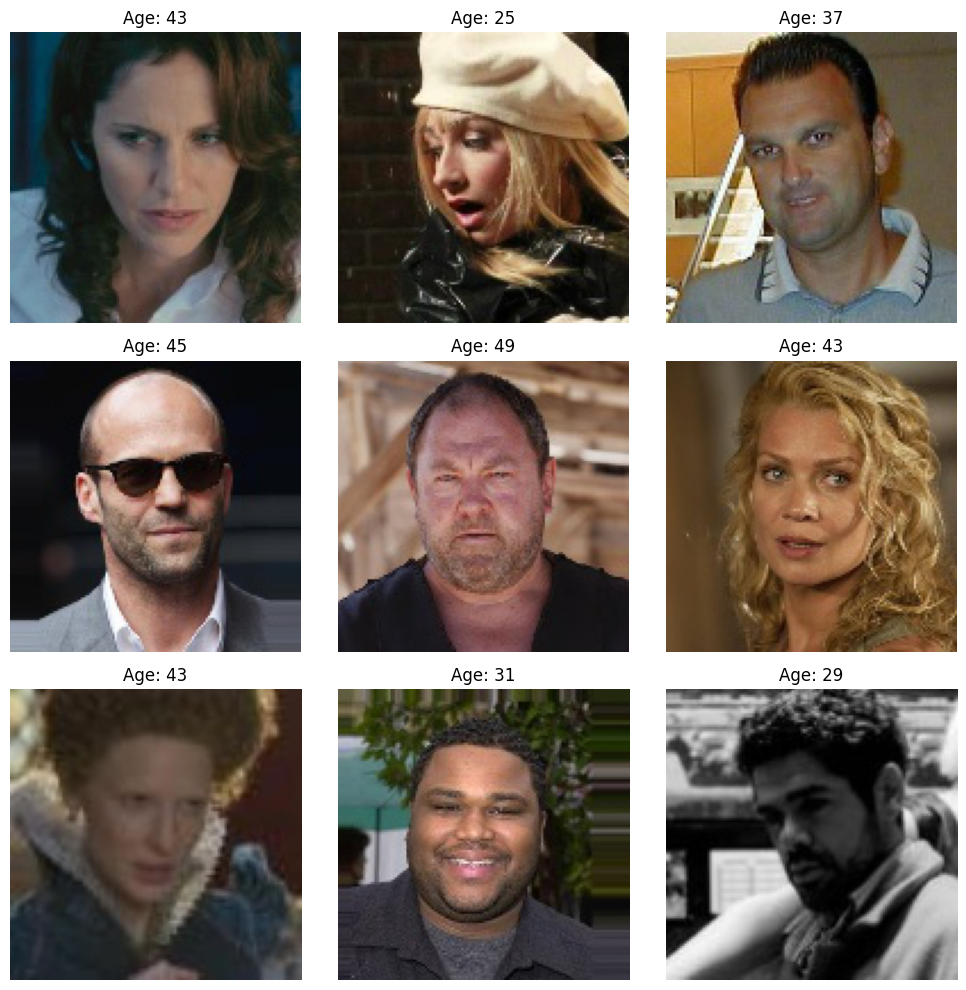

In [19]:
# Get total batch number for training set
TOTAL_TRA_BATCH = int(np.ceil(train.samples/BATCH_SIZE))

# Plot 9 images from train data
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(9):
    ax = axs[i//3][i%3]
    # Randomly choose 9 images from traingen
    batch = np.random.randint(0, TOTAL_TRA_BATCH-1)
    b_index = np.random.randint(0, BATCH_SIZE)
    x_batch, y_batch = train[batch]

    # Plot the image with the age as the title
    ax.imshow(x_batch[b_index])
    ax.set_title(f'Age: {int(y_batch[b_index]+age_bias)}')
    ax.axis('off')

fig.tight_layout()
fig.show()

**2.1.3[5 points]** **Conceptual Question**

**Answer:**

- Dropout is a regularization technique by randomly "dropping out" some weights when updating the networks. To do so, we multiply the weights matrix $W$ with a diagonal matrix $M$ (some elements on main diagonal are set to 0) to make the derivative of some weights become 0, therefore unable to update.

- Using dropout in FCNN is a good idea because it can drop some weights completely. However, in convolutional layer, the weights matrix $M$ is rather irregular so the 'dropped' weights will still be updated during Backprop, which is amount to multiplying Bernoulli noise into feature maps.

- So we will only add dropout in FCNN part of our model to avoid overfitting and to avoid over-reliance on particular features through reducing the number of times we calculate some neurons in training.

##### **Question 2.2**  Building and training your CNN [24 points]

**2.2.1[10 points]** **Define your regression model**.

In [20]:
# index == 'bn'
def get_model(name, output_units, output_activation, index='bn'):
    # Define model architecture
    model = Sequential(name = name+'_'+index)

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=IMG_SIZE+(3,)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.02)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dense(units=64, kernel_regularizer=tf.keras.regularizers.l2(0.02)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=output_units, activation=output_activation))

    return model

In [21]:
# regression_model ##########################################################################
model_2 = get_model(
    name = 'regression',
    output_units = 1,
    output_activation = 'linear'
)

# Compile the CNN model
model_2.compile(
    optimizer = Adam(),
    loss = 'mse'
)

# Take a look at the model summary
model_2.summary()

Model: "regression_bn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 32)    

**2.2.2[5 points]** **Training your model**.

In [22]:
# Define epochs for training
EPOCHS  = 30

# Dedine path to save model, and declare a bool type variable for skipping training
save_model_path = f'{PATH_PREFIX}model/{model_2.name}_{EPOCHS}.h5'
is_skip = (LOAD_MODELS['Part2_R']) and (os.path.exists(save_model_path))

# If skip training, use pretrained model
if is_skip:
    model_2.load_weights(save_model_path)
    print(f'-NOTICE: model load weights form {save_model_path}')

# If not, train a new model with early stopping
else:
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        verbose = 0,
        restore_best_weights = True
    )

    history = model_2.fit(
        train,
        validation_data = val,
        epochs = EPOCHS,
        callbacks = [earlystop]
    )

    print(f'-NOTICE: training process has finished.')


# Save the model weights in a file
if not is_skip:
    model_2.save_weights(filepath=save_model_path,save_format='h5')

    # If notebook is running on colab, also copy weights to google drive 
    if IS_COLAB:
        source = save_model_path
        target_dir = '/content/drive/MyDrive/model'
        shutil.copy(source, target_dir)
        print(f'-NOTICE: model copied to google drive successfully.')
else:
    print('-NOTICE: skiped training, so no need to save weights.')

Epoch 1/30
209/209 [==============================] - 77s 349ms/step - loss: 180.9351 - val_loss: 135.7936
Epoch 2/30
209/209 [==============================] - 68s 325ms/step - loss: 92.5089 - val_loss: 81.6154
Epoch 3/30
209/209 [==============================] - 70s 334ms/step - loss: 81.7963 - val_loss: 78.5106
Epoch 4/30
209/209 [==============================] - 70s 335ms/step - loss: 78.2934 - val_loss: 82.5633
Epoch 5/30
209/209 [==============================] - 67s 318ms/step - loss: 75.8211 - val_loss: 74.6993
Epoch 6/30
209/209 [==============================] - 67s 320ms/step - loss: 73.3484 - val_loss: 85.0467
Epoch 7/30
209/209 [==============================] - 68s 324ms/step - loss: 71.1899 - val_loss: 85.1694
Epoch 8/30
209/209 [==============================] - 69s 328ms/step - loss: 69.4771 - val_loss: 74.0514
Epoch 9/30
209/209 [==============================] - 67s 318ms/step - loss: 66.9695 - val_loss: 74.5258
Epoch 10/30
209/209 [==============================] 

**2.2.3[4 points] Evaluating your model.**

In [23]:
# Calculate predicted age on validation
prediction = model_2.predict(val)
age_pred = np.array(prediction.round(), dtype=int).reshape((-1,))
age_true = val.classes

53/53 [==============================] - 7s 134ms/step


In [24]:
# Get accuracy and loss for regression model on validation data
print(f'Regression model loss     on val: {mean_squared_error(age_true, age_pred)}')
print(f'Regression model accuracy on val: {accuracy_score(age_true, age_pred)}')

Regression model loss     on val: 66.62907568052647
Regression model accuracy on val: 0.04083158839365839


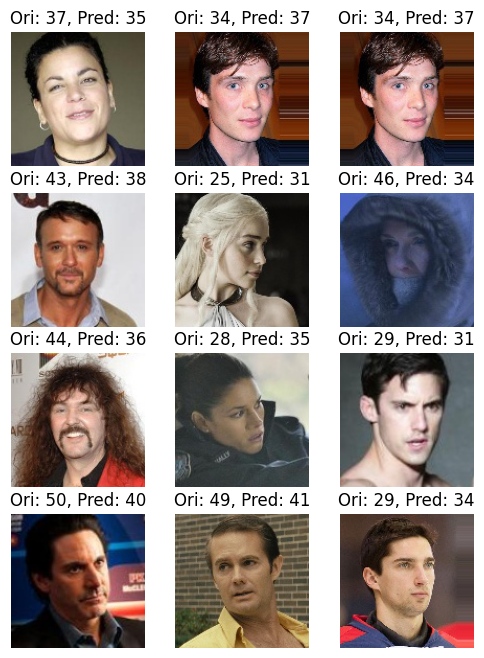

In [25]:
# Get total batch number for training set
TOTAL_TEST_BATCH = int(np.ceil(test.samples/BATCH_SIZE))

# Create a subplots with 4 rows and 3 columns
fig, axs = plt.subplots(4,3,figsize=(6,8))
for i in range(12):
    ax = axs[i//3][i%3]
    # Randomly choose 12 images from traingen
    batch = np.random.randint(0, TOTAL_TEST_BATCH-1)
    b_index = np.random.randint(0, BATCH_SIZE)
    x_batch, y_batch = train[batch]

    # Plot the image with the age as the title
    ax.imshow(x_batch[b_index])
    age_pred = model_2.predict(np.expand_dims(x_batch[b_index], axis=0),verbose=0)
    ax.set_title(f'Ori: {int(y_batch[b_index]+age_bias)}, Pred: {int(age_pred.round()+age_bias)}')
    ax.axis('off')
fig.show()

**2.2.4[5 points]** **Define a classification model**.

In [26]:
train_df = pd.read_csv(PATH_PREFIX+'data/Part2/age_train_data.csv')
class_num = len(np.unique(train_df['age']))

# classification_model ##########################################################################
model_3 = get_model(
    name = 'classification',
    output_units = class_num,
    output_activation = 'softmax'
)

# Compile the CNN model
model_3.compile(
    optimizer = Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Take a look at the model summary
model_3.summary()

Model: "classification_bn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 128, 128, 32)

In [27]:
# Define epochs for training
EPOCHS  = 30

# Dedine path to save model, and declare a bool type variable for skipping training
save_model_path = f'{PATH_PREFIX}model/{model_3.name}_{EPOCHS}.h5'
is_skip = (LOAD_MODELS['Part2_C']) and (os.path.exists(save_model_path))

# If skip training, use pretrained model
if is_skip:
    model_3.load_weights(save_model_path)
    print(f'-NOTICE: model load weights form {save_model_path}')

# If not, train a new model with early stopping
else:
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 5,
        verbose = 0,
        restore_best_weights = True
    )

    history = model_3.fit(
        train,
        validation_data = val,
        epochs = EPOCHS,
        callbacks = [earlystop]
    )

    print(f'-NOTICE: training process has finished.')


# Save the model weights in a file
if not is_skip:
    model_3.save_weights(filepath=save_model_path,save_format='h5')

    # If notebook is running on colab, also copy weights to google drive 
    if IS_COLAB:
        source = save_model_path
        target_dir = '/content/drive/MyDrive/model'
        shutil.copy(source, target_dir)
        print(f'-NOTICE: model copied to google drive successfully.')
else:
    print('-NOTICE: skiped training, so no need to save weights.')

Epoch 1/30
209/209 [==============================] - 73s 337ms/step - loss: 5.1913 - accuracy: 0.0366 - val_loss: 3.6530 - val_accuracy: 0.0326
Epoch 2/30
209/209 [==============================] - 70s 334ms/step - loss: 3.5928 - accuracy: 0.0392 - val_loss: 3.5217 - val_accuracy: 0.0375
Epoch 3/30
209/209 [==============================] - 67s 319ms/step - loss: 3.5248 - accuracy: 0.0431 - val_loss: 3.5200 - val_accuracy: 0.0410
Epoch 4/30
209/209 [==============================] - 70s 335ms/step - loss: 3.5170 - accuracy: 0.0441 - val_loss: 3.5192 - val_accuracy: 0.0359
Epoch 5/30
209/209 [==============================] - 67s 319ms/step - loss: 3.5207 - accuracy: 0.0425 - val_loss: 3.5687 - val_accuracy: 0.0405
Epoch 6/30
209/209 [==============================] - 67s 322ms/step - loss: 3.5248 - accuracy: 0.0484 - val_loss: 3.4975 - val_accuracy: 0.0444
Epoch 7/30
209/209 [==============================] - 69s 328ms/step - loss: 3.5039 - accuracy: 0.0520 - val_loss: 3.5243 - val_ac

In [28]:
# Get results on validation data
prediction = model_3.predict(val)
age_pred = np.argmax(prediction, axis=1)
age_true = val.classes

53/53 [==============================] - 8s 141ms/step


In [29]:
# Calculate accuracy
print(f'Classification model accuracy on validation: {accuracy_score(age_true, age_pred)}')

Classification model accuracy on validation: 0.06416392461860604


##### **Question 2.3** Further Analysis [6 points]

**2.3.1[3 points]** **Compare the performance**.

In [30]:
# Use both model to predict age on test set
prediction_r = model_2.predict(test)
prediction_c = model_3.predict(test)

55/55 [==============================] - 9s 160ms/step


In [31]:
# Calculate predicted age from predictions
age_pred_r = np.array(prediction_r.round(), dtype=int).reshape((-1,))
age_pred_c = np.argmax(prediction_c, axis=1)

# Get accuracy for both models on test data
age_true = test.classes
print(f'Regression     model accuracy on test: {accuracy_score(age_true, age_pred_r)}')
print(f'Classification model accuracy on test: {accuracy_score(age_true, age_pred_c)}')

Regression     model accuracy on test: 0.03738584474885845
Classification model accuracy on test: 0.0586472602739726


**2.3.2[3 points]** **Correct an image of your choosing**.

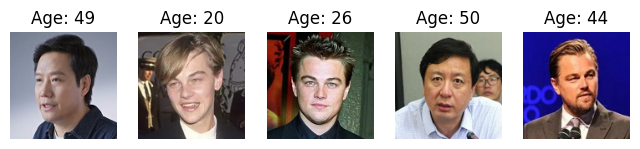

In [36]:
# Define x and y data
x = []
y_true = []

# Load 5 images and their true label
img_folder = PATH_PREFIX + 'data/Part2/my_data'
img_names = os.listdir(img_folder)
for img_name in img_names:
    img_path = os.path.join(img_folder, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path,target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    age = int(img_name.split('.')[0])

    x.append(img/255)
    y_true.append(age)
x = np.array(x)

# Plot the image with the age as the title
fig, axs = plt.subplots(1,5, figsize=(8,3))
for (ax, img, y) in zip(axs, x, y_true):
    ax.imshow(img)
    ax.set_title(f'Age: {y}')
    ax.axis('off')
fig.show()

# Predict age with both the models
y_pred_r = model_2.predict(x, verbose=0)
y_pred_c = model_3.predict(x, verbose=0)

In [37]:
# Calculate predicted age from y_predictions
y_age_r = np.array(y_pred_r.round(), dtype=int).reshape((-1,))
y_age_c = np.argmax(y_pred_c, axis=1)

# Print out original age and predicted ages
print(f'Original Age\t', end='')
for o in y_true:
    print(f'{o}\t',end='')
    
print(f'\nRegression\t', end='')
for r in y_age_r:
    print(f'{r + age_bias}\t',end='')
print(f'(MSE-log {np.round(np.log(mean_squared_error(y_true, y_age_r)),1)})')

print(f'Classification\t', end='')
for c in y_age_c:
    print(f'{c + age_bias}\t',end='')
print(f'(MSE-log {np.round(np.log(mean_squared_error(y_true, y_age_c)),1)})')

Original Age	49	20	26	50	44	
Regression	41	35	36	39	35	(MSE-log 6.3)
Classification	38	48	21	48	21	(MSE-log 6.7)


**Answer:** They both perform poorly, but classifiacation model performs better, relatively. For this result, reasons might be:

1. The regression model considers age as continuous data. Its loss function is define as MSE, so during training, when it's hard to tell the age, it might find a shortcut and learn to give the median of age data to minimize the loss. So the result is mostly around 35.

2. People's faces don't change much between their 20~50, and uncertain factors such as hair-style, makeup, mental state, etc. makes it even harder to give a exact age basing singly on ones face. Classification model can pick up some of the general features without being distracted by the value of age data.

3. Since classification model treats different age equally, so if it focuses on the wrong features (such as hair-style), the predicted data may be far from the real data because '20'->'23' and '20'->'50' are the same to the model. But if it focuses on the right features, the results are usually better than the regression model.
